# Capstone Project 2: Creating a Recommendation System for DJ Mixes using a Spotify User's preferences

## TOC:
* [1. Introduction](#1.-Introduction)
    * [1.1 Data Source and Importation](#1.1-Data-Source-and-Importation)
    * [1.2 Data Cleaning (Spotify)](#1.2-Data-Cleaning-(Spotify))
    * [1.3 Data Cleaning (1001tracklists.com)](#1.3-Data-Cleaning-(1001tracklists.com))
    * [1.4 Combining Datasets](#1.4-Combining-Datasets)
* [2. Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
    * [2.1 Differences in Sets/Mixes](#2.1-Differences-in-Sets/Mixes)
* [3. Recommendation Engine Building](#3.-Recommendation-Engine-Building)
    * [3.1 Artist Similarity Score](#3.1-Artist-Similarity-Score)
    * [3.2 Song Similarity Score](#3.2-Song-Similarity-Score)
    * [3.3 Set/Mix Popularity Score](#3.3-Set/Mix-Popularity-Score)
    * [3.4 Audio Feature Similarity Score](#3.4-Audio-Feature-Similarity-Score)

# 1. Introduction

I love being recommended and recommending new songs & artists to friends. But in today’s data-driven world, recommendation engines control the new content we see and hear. Whether it be a new product on Amazon, a new show on Netflix, or a new song in your discover weekly Spotify playlist, recommendation engines may know you better than anyone else. 

Let’s take a look at Spotify’s Discover Weekly feature as an example of a recommendation algorithm. It combines various methods, including content-based filtering methods, which looks at the raw audio features of a song to recommend new songs that are similar to songs you’ve listened to and liked before. A closer exploration of Spotify’s recommendation algorithm can be found here: https://medium.com/datadriveninvestor/behind-spotify-recommendation-engine-a9b5a27a935

Yet even with Spotify’s Discover Weekly feature, there aren’t any good recommendation systems for sets/mixes. When it comes to electronic music, I love recommending sets/mixes rather than individual songs because I believe they can more accurately convey the artist’s style. For example, an artist might play unreleased edits, IDs (i.e. unidentifiable songs, typically consisting of an unreleased song by the artist or an artist with a similar style), and play a myriad of songs ranging from their entire discography rather their most recent album. The set/mix might also include some mixing techniques (i.e. transitioning from one song to another) or other live elements that you won’t hear by streaming an individual song. Often times, it’s a combination of these additional “elements” to a set/mix that I want to recommend…and today’s recommendation engines simply don’t have the means to capture this type of data and recommend a set/mix. 

For my 2nd Capstone Project, I try to solve for this by utilizing content-based filtering methods to create a recommendation algorithm for sets/mixes. For this, I will need data on both a user’s music preferences and relevant data for sets/mixes. The biggest pitfall today is the lack of available data on sets/mixes and the ability to stream the actual set/mix itself. To combat this, I use Spotify’s Web API to pull a user’s top artists and created an automated-web scraper that searches for a Spotify user’s top artists on a 3rd party website that lists the artist’s most recent sets/mixes and the individual songs played in each set/mix along with other relevant metadata about the set/mix itself. 
* Problem: Creating a recommendation engine for sets/mixes using a Spotify user’s preferences and data scraped from 3rd party resources
* Dataset: Data queried from Spotify’s Web API, data scraped from 1001tracklist.com


# 1.1 Data Source and Importation

The data needed to build an effective recommendation system includes two kinds of inputs: data on **users** and data on **items**:

### Users: Spotify Users
* **Dataset Description**: JSON Objects containing a Spotify User’s top songs, top artists, and saved songs pulled directly from Spotify
* **Dataset Source**: Spotify’s Web API

### Items: Sets/Mixes
* **Dataset Description**: Dataframe containing up to 30 of the most recent sets/mixes played by the Spotify user’s top electronic artists with relevant metrics such as total views, total likes, individual songs played, genres, artists of other songs played, location, etc.
* **Dataset Source**: Data scraped via a custom-built automated web-scraper utilizing Selenium and BeautifulSoup on a 3rd party website that incentivizes users to list and identify songs played in a set/mix



# 1.2 Data Cleaning (Spotify)

### Overview of Spotify's Web API

To access a Spotify user’s music preferences, one must create and register an app and request authorization from both Spotify and the user

![title](SpotifyPic1.png)
![title](SpotifyPic2.png)

The diagrams above illustrate how a API call was processed to access user data. 

For the purposes of this report, the following should be noted:
* Different databases accessed via different scopes: Since we are accessing a Spotify User’s top songs, top artists, and saved songs as inputs to our recommendation engine, the following scopes were specified in our API call:
    * User-library-read
    * User-top-read

<table><tr>
<td> <img src="SpotifyPic3.png" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="SpotifyPic4.png" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

### Example API Request using my Spotify Account

For this report, I will use my personal Spotify data to illustrate how a Spotify user's data will be accessed:

In [1]:
#Importing from other files
from spotifyxx_v4 import *

#Importing other necessary packages
import os.path
import sys
import pandas as pd

Blame (NGHTMRE Remix) - Ekali
Forever (feat. Elohim) - Ekali
Helios - Ekali
Forever (feat. Elohim) - Laxcity Remix - Ekali
R U I N - Ekali
Jundo - Ekali
Forgot How To Dream (feat. K.Flay) - Ekali
Babylon (feat. Denzel Curry) - Skrillex & Ronny J Remix - Ekali
Babylon (feat. Denzel Curry) - Ekali
Leaving (feat. Yuna) - Ekali
Blame - Ekali
Take a Walk - Passion Pit
Sleepyhead - Passion Pit
thank u, next - Ariana Grande
break up with your girlfriend, i'm bored - Ariana Grande
7 rings - Ariana Grande
Everything (feat. RIA) - Rusty Hook
X / Love - Hex Cougar
No Friend Zone - VAVO
F8 - DELAY.
0 Ya Kidding - Solardo Remix FISHER
1 Losing It - Radio Edit FISHER
2 Stop It FISHER
3 Losing It FISHER
4 Crowd Control FISHER
5 Ya Didn't FISHER
6 Lake Placid OZZIE
7 Blame Ekali
8 XILLA! MEMBA
9 Golden Fur Elfkowitz
10 Splitting The Atom Massive Attack
11 Ya Kidding - Sébastien V (BE) Remix FISHER
12 Hotbox Liquid Stranger
13 Affirmative Action Nas
14 Little Dark Age MGMT
15 Soul to Seoul TOKiMONSTA
1

### Getting Unique List of Songs, Artists, and Audio Features of Songs

I first created dictionaries for Artists and Songs with the following keys:

#### Artist Dictionary

In [2]:
artist_dict = {
        "artist_name": "",
        "artist_genre": "",
        "artist_popularity": 0,
        "artist_followers": 0,
}

#### Song Dictionary

In [3]:
song_features = {
        "key": 0,
        "mode": 0,
        "time_signature": 0,
        "acousticness": 0,
        "danceability": 0,
        "energy": 0,
        "loudness": 0,
        "tempo": 0,
        "id": "",
        "uri": "",
        "instrumentalness": 0,
        "valence": 0,
        "name": "",
}

#### Dataframes

I then converted each dictionary into a dataframe. 

In [4]:
print(topArtists_DF.head())
print(top_songs_DF.head())
print(saved_songs_DF.head())
print(songFeatures_DF.head())

   artist_followers                                       artist_genre  \
0          18211268                                              [pop]   
1             52316  [brostep, electro house, electronic trap, moom...   
2            158848  [aussietronica, australian electropop, austral...   
3             72494  [bass trap, brostep, canadian electronic, edm,...   
4            101343            [emo, neon pop punk, pop emo, pop punk]   

  artist_name  artist_popularity  EDM_Artist  
0    Maroon 5                 89       False  
1          4B                 50       False  
2  Peking Duk                 64        True  
3       Ekali                 61        True  
4    Go Radio                 53       False  
  song_artist                 song_id                   song_name
0      FISHER  2HQ1XA5iHCpnTJlVaqJ4iN  Ya Kidding - Solardo Remix
1      FISHER  2KXwJZv1pRQFQ95Kj60jBN      Losing It - Radio Edit
2      FISHER  4qetR2UUyBeUrJ9DbYrpVQ                     Stop It
3      FI

Since the recommendation engine is using data for sets/mixes from 1001tracklists.com, I also flag if an artist has an "electronic" genre because 1001tracklists.com is primarily focused on electronic music.

In [5]:
#Flagging artist if artist is an EDM artist
topArtists_DF["EDM_Artist"] = topArtists_DF["artist_genre"].map(lambda x: "edm" in x)
edmArtists_DF = topArtists_DF.loc[(topArtists_DF["EDM_Artist"] == True)]

In [6]:
print(topArtists_DF)

    artist_followers                                       artist_genre  \
0           18211268                                              [pop]   
1              52316  [brostep, electro house, electronic trap, moom...   
2             158848  [aussietronica, australian electropop, austral...   
3              72494  [bass trap, brostep, canadian electronic, edm,...   
4             101343            [emo, neon pop punk, pop emo, pop punk]   
5             463588  [edm, electronic trap, pop, pop edm, tropical ...   
6            7027054      [dance pop, edm, miami hip hop, pop, pop rap]   
7              30187  [bass trap, brostep, electro house, electronic...   
8               2387                                                 []   
9             187242  [brostep, edm, electro house, electronic trap,...   
10              1226                                                 []   
11            937698                          [edm, electro house, pop]   
12             20371     

In [116]:
#Creating unique list of edm artists to search with selenium on 1001tracklists.com
unique_edmArtists = []
unique_edmArtists = list(edmArtists_DF["artist_name"])

For the purposes of this report, I look at a random artist in my top EDM Artists I listen to. This artist will be the one I use for my scraper:

In [133]:
print(unique_edmArtists[1])

Ekali


# 1.3 Data Cleaning (1001tracklists.com)

### Overview of 1001tracklists.com

1001tracklist.com is a 3rd party resource where users provide a link to the actual set/mix (e.g. Youtube link, Soundcloud link, Mixcloud link, etc.) and list out the artists and name of the individual songs played in the set/mix. Other relevant metadata that was scraped include total webpage views, date played, total set/mix likes, genres, duration of each individual song, number of individual songs played and number of songs actually identified.

Shown below is an example webpage from 1001tracklists.com:

![title](1001tracklistPic1.png)

To get the necessary data for sets/mixes, I created an automated web scraper using selenium and beautifulsoup

In [8]:
#importing relevant packages for automated web navigation
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.action_chains import ActionChains

#Importing other relevant modules
import unicodedata
from urllib.request import Request, urlopen

### Set/Mix Dictionary

I stored the data in the following dictionary:

In [9]:
song_dict = {
    "TL_Name": "",
    "TL_URL": "",
    "TL_SC_Link": "None",
    "TL_Youtube_Link": "None", 
    "TL_Date": "",
    "TL_Views": "",
    "TL_Likes": "",
    "TL_Number_IDed": "",
    "TL_Genres": "",
    "TL_Sources": "",
    "TL_Avg_Spotify_Danceability": 0,
    "TL_Avg_Spotify_Energy": 0,
    "TL_Avg_Spotify_Tempo": 0,
    "TL_Avg_Spotify_Valence": 0,
    "TL_SongName": "",
    "TL_SongArtist": "",
    "TL_SongRemixFlag": False,
    "TL_PositionSeconds": "",
}

The hardest data to scrape were the available Spotify links to each identified track in each set/mix as the links were only shown on actual "clicks". As such, Selenium was used to navigate to each set/mix page and click each Spotify link. Only then was I able to use BeautifulSoup to capture the Spotify unique ID of each identified track which was useful in measuring the set/mix's average Spotify Danceablity, Energy, Tempo, and Valence which will play a major role in recommending the right set/mix.

![title](1001tracklistPic2.png)

### Running the automated web scraper

For the purposes of this report, I don't show all the code used in the automated browser navigation and scraping used to obtain the set/mix data. See related files on my github for the actual code. Below I show an example output of the scraper that I've outputted to a local Excel file. I limited the output to the first 5 sets instead of the most recent 30 but plan to do a more in-depth report on more artists and more sets/mixes later on.

In [148]:
#Running the automated web scraper
Master_DF = pd.read_excel("masterdata0604.xlsx")
Master_DF = Master_DF.drop_duplicates(subset=["TL_Name","TL_SongName","TL_SongArtist"])
print(Master_DF.tail())

     Unnamed: 0                           TL_Name  TL_URL TL_SC_Link  \
281          77  Ekali @ EDC Las Vegas 2019-05-19     NaN       None   
282          78  Ekali @ EDC Las Vegas 2019-05-19     NaN       None   
283          79  Ekali @ EDC Las Vegas 2019-05-19     NaN       None   
285          81  Ekali @ EDC Las Vegas 2019-05-19     NaN       None   
286          82  Ekali @ EDC Las Vegas 2019-05-19     NaN       None   

    TL_Youtube_Link     TL_Date  TL_Views  TL_Likes  TL_Number_IDed  \
281            None  2019-05-19      5027         7             NaN   
282            None  2019-05-19      5027         7             NaN   
283            None  2019-05-19      5027         7             NaN   
285            None  2019-05-19      5027         7             NaN   
286            None  2019-05-19      5027         7             NaN   

                  TL_Genres          TL_Sources  TL_Avg_Spotify_Danceability  \
281  Dubstep, Hip Hop, Trap  EDC Las Vegas 2019             

# 2. Exploratory Data Analysis

To illustrate the need for recommendation systems for sets/mixes, I try to highlight how significantly different sets/mixes can be by a single artist through exploratory data analysis.

In [153]:
#Importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2.1 Differences in Sets/Mixes

Due to data quality issues resulting from inconsistencies between 1001tracklists.com webpages and the nature of the data being manually inputted by users, I select 3 sets/mixes that I believe to be of high data quality:

In [175]:
Good_Quality_Sets = Master_DF.loc[Master_DF["TL_Name"].isin(["Ekali @ Orlando Amphitheater 2019-02-02","Ekali @ EDC Las Vegas 2019-05-19","Ekali & Cold Blue - Night Owl Radio 187 2019-03-22"])]
Good_Quality_Sets.groupby("TL_Name")["TL_SongName"].count()

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22    26
Ekali @ EDC Las Vegas 2019-05-19                      81
Ekali @ Orlando Amphitheater 2019-02-02               63
Name: TL_SongName, dtype: int64

Already we can see that there was a significant difference in tracks played, which is unusual given that the length of each set was generally similar. Looking at the differences between the individual tracks of each set might shed some light as to why there is this big of a discrepancy.

### Genre Differences between Sets

In [184]:
Good_Quality_Sets.groupby("TL_Name")["TL_Genres"].unique()

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22                    [Trap, Trance]
Ekali @ EDC Las Vegas 2019-05-19                            [Dubstep, Hip Hop, Trap]
Ekali @ Orlando Amphitheater 2019-02-02               [Electro House, Hip Hop, Trap]
Name: TL_Genres, dtype: object

Right away we notice that the sets with less tracks played include more house and trance, genres in which songs are generally played for a longer duration. Let's corroborate this with the average tempo of each set that we scraped and brought in utilizing Spotify's Web API

In [254]:
Good_Quality_Sets.groupby("TL_Name")["TL_Avg_Spotify_Tempo"].unique()

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22               [130.03]
Ekali @ EDC Las Vegas 2019-05-19                                [140.052]
Ekali @ Orlando Amphitheater 2019-02-02               [154.6813333333334]
Name: TL_Avg_Spotify_Tempo, dtype: object

![title](genresPic.png)

With a quick google search on typical BPMs/Tempos for different genres, I was able to contextualize the differences in average tempo of each set we obtained from Spotify with the differences in scraped genres(s) of each set we obtained from 1001tracklist.com. 

### Other Spotify Metrics

Some other interesting metrics Spotify captures is the danceability or valence of an individual song. Each song is measured on a scale from 0 to 1 (more details on this in the diagram below)

<table><tr>
<td> <img src="danceability.png" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="valence.png" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>

We have already established that there is a significant difference between genres/tempos between the 3 sets we've looked at despite the fact that it was played by the same artist. Let's see if this translates into differences in danceability and valence (i.e. "mood").

In [276]:
Good_Quality_Sets.groupby("TL_Name")["TL_Avg_Spotify_Danceability"].unique()

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22                 [0.861]
Ekali @ EDC Las Vegas 2019-05-19                                   [0.657]
Ekali @ Orlando Amphitheater 2019-02-02               [0.5163333333333333]
Name: TL_Avg_Spotify_Danceability, dtype: object

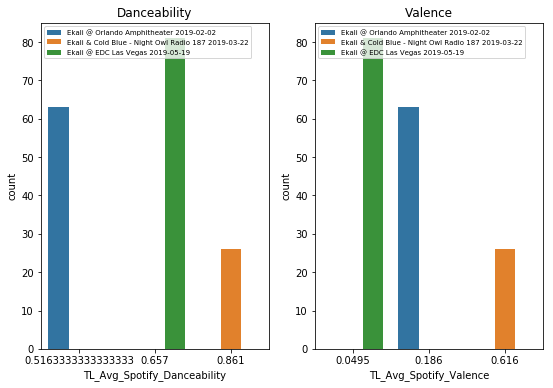

In [277]:
fig, axes = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(9, 6)

#Danceability
Danceability_Plot = sns.countplot(x = "TL_Avg_Spotify_Danceability", hue = "TL_Name", data = Good_Quality_Sets, ax = axes[0])
axes[0].set_title("Danceability")
axes[0].legend(loc = "upper left", fontsize = 7)

#Valence
Valence_Plot = sns.countplot(x = "TL_Avg_Spotify_Valence", hue = "TL_Name", data = Good_Quality_Sets, ax = axes[1])
axes[1].set_title("Valence")
axes[1].legend(loc = "upper left", fontsize = 7)

### Summary of Findings

* **Established a correlation between Genre and Tempo:** More data and further statistical testing can be conducted to see if this remains true across multiple genres/artists.
* **Established initial hypothesis that there are differences between sets by the same artist:** Both the danceability and mood of 3 of the most recent sets played by the same artist differed significantly. This will be useful in building out our recommendation engine using a Spotify User's most recently listened to songs, saved songs, and top artists

# 3. Recommendation Engine Building

Since my goal is to recommend a set/mix that a Spotify User will most likely like, I will try to score each set/mix based on 4 factors:
* Set's Artist Similarity to current top Artists
* Set's Song Similiarty to current top Songs and saved Songs
* Set's Overall popularity based on 1001tracklists.com
* Audio Feature Similarities between current top Songs and saved Songs with the Set's Average Audio Feature Metrics

In [444]:
#Creating a new Dataframe to score each set
set_order = Master_DF.groupby("TL_Name")["New_Col_Artist_Flag"].value_counts()
set_order = set_order.groupby(level = 0).apply(lambda x: x.iloc[0:1])
set_order.index = set_order.index.droplevel(0)
set_order = list(set_order.index)

SetNames = set_order
ArtistSimilarity = {"ArtistSimilarity": [1, 1, 1, 1]}
SongSimilarity = {"SongSimilarity": [1, 1, 1, 1]}
TLPopularity = {"TLPopularity": [1, 1, 1, 1]}
AFSimilarity = {"AFSimilarity": [2, 2, 2, 2]}
scoring_d = {"SetNames": set_order, "ArtistSimilarity": [1, 1, 1, 1, 1, 1], "SongSimilarity": [1, 1, 1, 1, 1, 1], "TLPopularity": [1, 1, 1, 1, 1, 1], "AFSimilarity": [2, 0, 0, 2, 2, 0]}

scoring_DF = pd.DataFrame(data = scoring_d)
scoring_DF

,SetNames,ArtistSimilarity,SongSimilarity,TLPopularity,AFSimilarity
0,(Ekali & Cold Blue - Night Owl Radio 187 2019-...,1,1,1,2
1,"(Ekali - Awakening Mix #7 2019-04-16, False)",1,1,1,0
2,"(Ekali @ Beyond Wonderland 2019-03-23, False)",1,1,1,0
3,"(Ekali @ EDC Las Vegas 2019-05-19, False)",1,1,1,2
4,"(Ekali @ Orlando Amphitheater 2019-02-02, False)",1,1,1,2
5,(Ekali @ SIAM Songkran Music Festival 2019-04-...,1,1,1,0


In [445]:
#Converting spotify user's unique artists and songs into regex pattern
artist_regex_pattern = '|'.join(unique_artists)
song_regex_pattern = '|'.join(unique_songs)

In [446]:
#Creating a new column in dataframe if artist match is found in tracklist
Master_DF["New_Col_Artist_Flag"] = Master_DF["TL_SongArtist"].str.contains(artist_regex_pattern).fillna('')

#Creating a new collumn in dataframe if song match is found in tracklist
Master_DF["New_Col_Song_Flag"] = Master_DF["TL_SongName"].str.contains(song_regex_pattern).fillna('')

/anaconda2/envs/springboard/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """


# 3.1 Artist Similarity Score

In [447]:
#Creating an Artist Similarity Score
Master_DF.groupby("TL_Name")["New_Col_Artist_Flag"].value_counts()
AS = Master_DF.groupby("TL_Name")["New_Col_Artist_Flag"].sum()/Master_DF.groupby("TL_Name")["New_Col_Artist_Flag"].count()
print(AS)
AS = list(AS)

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22    0.000000
Ekali - Awakening Mix #7 2019-04-16                   0.043478
Ekali @ Beyond Wonderland 2019-03-23                  0.312500
Ekali @ EDC Las Vegas 2019-05-19                      0.259259
Ekali @ Orlando Amphitheater 2019-02-02               0.301587
Ekali @ SIAM Songkran Music Festival 2019-04-14       0.275862
Name: New_Col_Artist_Flag, dtype: float64


# 3.2 Song Similarity Score

In [448]:
#Creating a Song Similarity Score
Master_DF.groupby("TL_Name")["New_Col_Song_Flag"].value_counts()
SS = Master_DF.groupby("TL_Name")["New_Col_Song_Flag"].sum()/Master_DF.groupby("TL_Name")["New_Col_Song_Flag"].count()
print(SS)
SS = list(SS)

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22    0.000000
Ekali - Awakening Mix #7 2019-04-16                   0.000000
Ekali @ Beyond Wonderland 2019-03-23                  0.156250
Ekali @ EDC Las Vegas 2019-05-19                      0.074074
Ekali @ Orlando Amphitheater 2019-02-02               0.079365
Ekali @ SIAM Songkran Music Festival 2019-04-14       0.086207
Name: New_Col_Song_Flag, dtype: float64


# 3.3 Set/Mix Popularity Score

In [467]:
Likes = Master_DF.groupby("TL_Name")["TL_Likes"].unique()
Views = Master_DF.groupby("TL_Name")["TL_Views"].unique()
print(Likes)
print(Views)
PS = Likes / Views
#Figure out how to unpack list of arrays into list
PS = [0.00180505, 0.00133761, 0, 0.00139248, 0.00146413, 0.00104112]

TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22    [2]
Ekali - Awakening Mix #7 2019-04-16                   [5]
Ekali @ Beyond Wonderland 2019-03-23                  [0]
Ekali @ EDC Las Vegas 2019-05-19                      [7]
Ekali @ Orlando Amphitheater 2019-02-02               [3]
Ekali @ SIAM Songkran Music Festival 2019-04-14       [2]
Name: TL_Likes, dtype: object
TL_Name
Ekali & Cold Blue - Night Owl Radio 187 2019-03-22    [1108]
Ekali - Awakening Mix #7 2019-04-16                   [3738]
Ekali @ Beyond Wonderland 2019-03-23                   [882]
Ekali @ EDC Las Vegas 2019-05-19                      [5027]
Ekali @ Orlando Amphitheater 2019-02-02               [2049]
Ekali @ SIAM Songkran Music Festival 2019-04-14       [1921]
Name: TL_Views, dtype: object


# 3.4 Audio Feature Similarity Score

In [468]:
#My Personal Spotify Data
print(songFeatures_DF.describe())

       acousticness  danceability     energy  instrumentalness        key  \
count     69.000000     69.000000  69.000000         69.000000  69.000000   
mean       0.134381      0.609594   0.693826          0.246218   6.072464   
std        0.184917      0.113371   0.160771          0.340270   3.524364   
min        0.000753      0.276000   0.272000          0.000000   0.000000   
25%        0.015100      0.542000   0.615000          0.000017   4.000000   
50%        0.057100      0.612000   0.719000          0.002340   6.000000   
75%        0.188000      0.678000   0.811000          0.494000   9.000000   
max        0.881000      0.898000   0.964000          0.943000  11.000000   

        loudness       mode       tempo  time_signature    valence  
count  69.000000  69.000000   69.000000       69.000000  69.000000  
mean   -6.344580   0.362319  125.588971        3.985507   0.303429  
std     2.392587   0.484192   30.195341        0.120386   0.193038  
min   -12.928000   0.000000   

In [469]:
#Looking at just Danceability and Valence
MyCurrentDanceability = songFeatures_DF["danceability"].mean()
MyCurrentMood = songFeatures_DF["valence"].mean()

#Grabbing average danceability and valence from spotify x 1001tracklist data
avg_set_danceability = list(Good_Quality_Sets.groupby("TL_Name")["TL_Avg_Spotify_Danceability"].unique())
avg_set_mood = list(Good_Quality_Sets.groupby("TL_Name")["TL_Avg_Spotify_Valence"].unique())

In [470]:
#Initializing diff in means array
diff_means_danceability = []
diff_means_mood = []

#Calculating abs difference from mean from each quality set
for set in avg_set_danceability:
    diff_means_danceability.append(abs(MyCurrentDanceability - float(set)))
#repeat for mood    
for set in avg_set_mood:
    diff_means_mood.append(abs(MyCurrentMood - float(set)))

In [471]:
AF_List = list(Good_Quality_Sets["TL_Name"].unique())
print(diff_means_danceability)
print(diff_means_mood)

[0.2514057971014495, 0.04740579710144954, 0.09326086956521717]
[0.3125710144927536, 0.2539289855072464, 0.1174289855072464]


In [472]:
AF_weight = []
for i in range(3):
    AF_weight.append((diff_means_danceability[i] + diff_means_mood[i]) / 2)
AF_weights = [AF_weight[0], 0, 0, AF_weight[1], AF_weight[2], 0]

# 3.5 Final Recommendation

In [473]:
#print(scoring_DF["ArtistSimilarity"] * AS)
#print(scoring_DF["SongSimilarity"] * SS)
#print(scoring_DF["TLPopularity"] * PS)
#GoodQualityFlag = '|'.join(AF_List)
#scoring_DF["AF_Flag"] = scoring_DF["SetNames"].str.contains(GoodQualityFlag).fillna('')
#print(scoring_DF["AFSimilarity"] * AF_weights)

final_rec = scoring_DF
final_rec["ArtistSimilarity"] = final_rec["ArtistSimilarity"] * AS
final_rec["SongSimilarity"] = final_rec["SongSimilarity"] * SS
final_rec["TLPopularity"] = final_rec["TLPopularity"] * PS
final_rec["ArtistSimilarity"] = final_rec["ArtistSimilarity"] * AF_weights

In [474]:
final_rec["Overall_Score"] = final_rec["ArtistSimilarity"] + final_rec["SongSimilarity"] + final_rec["TLPopularity"] + final_rec["ArtistSimilarity"]

In [478]:
final_rec

,SetNames,ArtistSimilarity,SongSimilarity,TLPopularity,AFSimilarity,Overall_Score
0,(Ekali & Cold Blue - Night Owl Radio 187 2019-...,0.000000,0.000000,0.001805,2,0.001805
1,"(Ekali - Awakening Mix #7 2019-04-16, False)",0.000000,0.000000,0.001338,0,0.001338
2,"(Ekali @ Beyond Wonderland 2019-03-23, False)",0.000000,0.024414,0.000000,0,0.024414
3,"(Ekali @ EDC Las Vegas 2019-05-19, False)",0.010127,0.005487,0.001392,2,0.027134
4,"(Ekali @ Orlando Amphitheater 2019-02-02, False)",0.009582,0.006299,0.001464,2,0.026926
5,(Ekali @ SIAM Songkran Music Festival 2019-04-...,0.000000,0.007432,0.001041,0,0.008473
